## Data and Text mining

Data mining and Text mining are an essential step in data science, but they are different. Since they have many terminologies overlap each other, they tend to get quite confusing, especially for those trying to find their way around the realm of data science.
The purpose of the data science fields is to get insight from the data. To get the actual insight, the data needs to be clean and useful. Data mining is a process used to find and extract patterns within a large set of data. At its core, statistical methodologies is used to describe the relations in the data.

In this notebook, I would like to demonstrate basic Data mining techniques related to Text mining by using real data.


## About the data set
We use the data set contains all vehicle safety-related defect complaints received by NHTSA since January 1, 1995.

The United States Department of Transportation established the Natinal Highway Traffic Safety Administration (NHTSA), so that information on all vehicle safety-related issues is available to sonsumers. NHTSA accepts complaints on auto safety issues, through their website or other channels such as email or phone. Users can enter information about the vehicle (Make - Model - Year) and the incident that contains both constrained choice fields and free text input. As a result, the data available for an incident contains the mixture of structured and unstructured data.

The resulting data by the Office of Defects Investigation (ODI) of NHTSA is made publicly available on [NHTSA/ODI Databases](https://www-odi.nhtsa.dot.gov/downloads/). These contents are anonymous in that they do not contain personal identities or license plates. On the complaints data, the field for `COMPDESC` is filled to describe the affected parts.

The latest data set is downloaded locally by executing the following code.

In [1]:
import os.path
import urllib3
import zipfile
import shutil
nhtsa_dir = 'nhtsa'
nhtsa_complaints = os.path.join(nhtsa_dir, 'FLAT_CMPL.txt')

if os.path.exists(nhtsa_complaints):
    print("All complaints file already exists.")
else:
    print("Downloading all complaints.")
    http = urllib3.PoolManager()
    url = 'https://www-odi.nhtsa.dot.gov/downloads/folders/Complaints/FLAT_CMPL.zip'
    path = 'FLAT_CMPL.zip'
    
    with http.request('GET', url, preload_content=False) as r, open(path, 'wb') as out_file:       
        shutil.copyfileobj(r, out_file)
    
    print("Unzipping " + path)
    with zipfile.ZipFile(path, 'r') as zf:
        zf.extractall(nhtsa_dir)
    
    print("Removing " + path)
    os.remove(path)

All complaints file already exists.


The downloaded complaints are TAB delimited with no headers and 49 fields (see: [CMPL.txt](https://www-odi.nhtsa.dot.gov/downloads/folders/Complaints/CMPL.txt) for data schema). This data set is loaded into a pandas's DataFrame for further analysis. corrupted records to load the all records.

In [2]:
import csv
import pandas as pd

df = pd.read_csv(
    nhtsa_complaints, 
    header=None, 
    encoding='latin1', 
    delimiter='\t', 
    quoting=csv.QUOTE_NONE, 
    error_bad_lines=False, 
    warn_bad_lines=True,
    index_col=False,
    dtype=str,
#    nrows=200000,
)

df.columns = [
    'CMPLID','ODINO','MFR_NAME','MAKETXT','MODELTXT','YEARTXT','CRASH','FAILDATE','FIRE','INJURED','DEATHS','COMPDESC','CITY',
    'STATE','VIN','DATEA','LDATE','MILES','OCCURENCES','CDESCR','CMPL_TYPE','POLICE_RPT_YN','PURCH_DT','ORIG_OWNER_YN',
    'ANTI_BRAKES_YN','CRUISE_CONT_YN','NUM_CYLS','DRIVE_TRAIN','FUEL_SYS','FUEL_TYPE','TRANS_TYPE','VEH_SPEED','DOT',
    'TIRE_SIZE','LOC_OF_TIRE','TIRE_FAIL_TYPE','ORIG_EQUIP_YN','MANUF_DT','SEAT_TYPE','RESTRAINT_TYPE','DEALER_NAME',
    'DEALER_TEL','DEALER_CITY','DEALER_STATE','DEALER_ZIP','PROD_TYPE','REPAIRED_YN','MEDICAL_ATTN','VEHICLES_TOWED_YN']

b'Skipping line 1014030: expected 49 fields, saw 50\n'
b'Skipping line 1189857: expected 49 fields, saw 50\n'
b'Skipping line 1274881: expected 49 fields, saw 50\n'
b'Skipping line 1279744: expected 49 fields, saw 50\nSkipping line 1279745: expected 49 fields, saw 50\nSkipping line 1279746: expected 49 fields, saw 50\n'
b'Skipping line 1299672: expected 49 fields, saw 50\nSkipping line 1304644: expected 49 fields, saw 50\nSkipping line 1306559: expected 49 fields, saw 50\n'
b'Skipping line 1313277: expected 49 fields, saw 50\nSkipping line 1316683: expected 49 fields, saw 50\n'
b'Skipping line 1366362: expected 49 fields, saw 50\nSkipping line 1375991: expected 49 fields, saw 50\n'
b'Skipping line 1383938: expected 49 fields, saw 50\n'
b'Skipping line 1436839: expected 49 fields, saw 50\nSkipping line 1436840: expected 49 fields, saw 50\nSkipping line 1441035: expected 49 fields, saw 50\n'
b'Skipping line 1447629: expected 49 fields, saw 50\n'
b'Skipping line 1464715: expected 49 field

This data set has 3 date type fields, however some of the fields have corrupted values. We need to drop the records with invalid or problematic values in date type format so that these date fields can be converted into date type field in DataFrame. 



In [3]:
date_fields = ['FAILDATE', 'DATEA', 'LDATE', 'PURCH_DT', 'MANUF_DT']

# drop rows with invalid values in datetime fields like '0YYYYMDD'
for date_field in date_fields:
    # drop error values in datetime fields like `0YYYYMDD`
    df = df[(df[date_field].isna()) | (df[date_field].str.match(r'(?P<year>(19|20)\d{2})(?P<month>\d{1})(?P<day>\d{2})'))]

# convert to datetime type
for date_field in date_fields:
    df[date_field] = pd.to_datetime(df[date_field])


## Quick look on the data set
This data set has more than 1.7 million records with 49 fields (as of 2021-05-17).

In [4]:
df

,CMPLID,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,...,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
0,998000000,0,Ford Motor Company,MERCURY,TRACER,1994,N,1998-06-30,N,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,N,N,N
1,998000001,0,"Chrysler (FCA US, LLC)",PLYMOUTH,LASER,1990,N,1998-10-06,N,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,N,N,N
2,997000002,0,Mazda Motor Corp.,MAZDA,MPV,1992,N,1997-03-31,N,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,N,N,N
3,997000003,0,Mazda Motor Corp.,MAZDA,MPV,1992,N,1997-03-31,N,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,N,N,N
4,997000004,0,Mazda Motor Corp.,MAZDA,MPV,1992,N,1997-03-31,N,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728096,021113703,11416529,"Chrysler (FCA US, LLC)",RAM,1500,2020,N,2021-05-11,N,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,N,N,N
1728097,019113704,11416530,Kia Motors America,KIA,OPTIMA,2018,N,2019-07-19,N,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,N,N,N
1728098,019113705,11416530,Kia Motors America,KIA,OPTIMA,2018,N,2019-07-19,N,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,N,N,N
1728099,019113706,11416530,Kia Motors America,KIA,OPTIMA,2018,N,2019-07-19,N,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,N,N,N


The following figure shows the number of complaints for each year from 1995 to 2021.

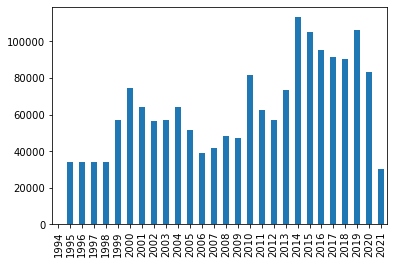

In [5]:
timeseries = df['LDATE'].value_counts().resample('YS').sum()
ax = timeseries.plot(kind='bar')
# beware that '_' is important to absorb matplotlib verbose messages
_ = ax.set_xticklabels([x.strftime("%Y") for x in timeseries.index])


The following shows the most 30 frequent components in the all complaints data.

<AxesSubplot:>

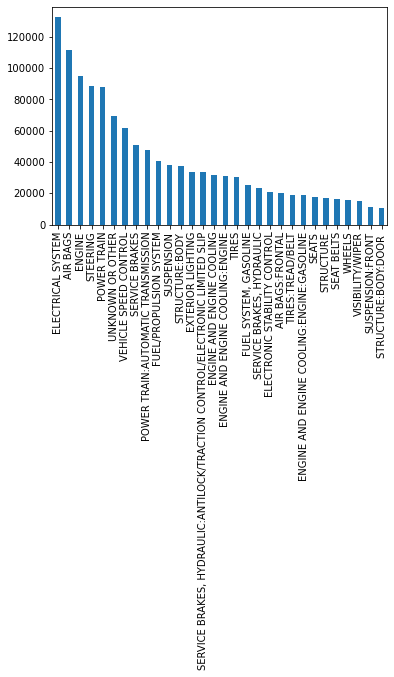

In [6]:
df['COMPDESC'].value_counts().head(30).plot(kind='bar')

## Toyota Tundra Recall for Frame Rust
Toyota has recalled some of its Tundra pickups for dangerous frame corrosion. This problem could eventually cause the frame to break apart, potentially causing serious accidents, but in any case making the trucks unusable. The Tundra recall affects the model years 2000-2003, sold in or registered in states where corrosive road salt is an issue.
- Recall Subject: REAR CROSS MEMBER ASSEMBLY CORROSION
- Report Receipt Date: NOV 18, 2009
- NHTSA Campaign Number: 09V444000
- Component(s): STRUCTURE

The data uncovers this actual recall case. 


## Which components are highly relevant to "Toyota Tundra"
The following figure shows the 30 most frequent components to "Toyota Tundra". The `STRUCTURE:BODY` component is the most frequent component in the set of complaints to `TUNDRA` model.

<AxesSubplot:>

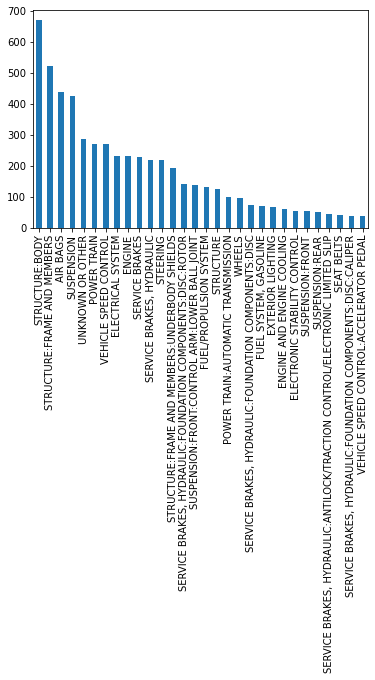

In [7]:
df_modeltxt = df[df['MODELTXT']=='TUNDRA']
compdesc_modeltxt=df_modeltxt['COMPDESC']
compdesc_modeltxt.value_counts().head(30).plot(kind='bar')

The following figure shows the 30 most relevant components to "Toyota Tundra". The 30 most frequents components are sorted by PMI (Pointwise Mutual Information) measure. This measure represents how strongly the component is related to the set of complaints to `TUNDRA` model, compared to the other complaints in this data set. Therefore, the `STRUCTURE: FRAME AND MEMBERS:UNDERBODY SHIELDS` components is more specifically related to "Toyota Tundra" in this data set.


<AxesSubplot:>

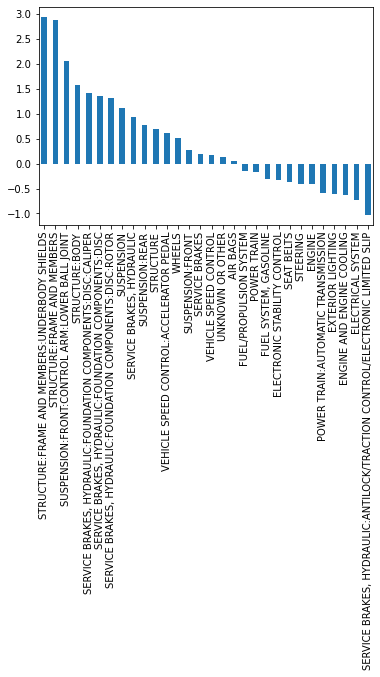

In [8]:
import math

corpus_count = len(df)
modeltxt_count = len(df_modeltxt)
compdesc_modeltxt_counts = compdesc_modeltxt.value_counts().head(30)
compdesc_modeltxt_pmi = pd.Series(name='pmi', dtype='float64')
for compdesc in compdesc_modeltxt_counts.index:
    compdesc_count = (df['COMPDESC']==compdesc).sum()
    compdesc_modeltxt_count = compdesc_modeltxt_counts[compdesc]
    pmi = math.log( (compdesc_modeltxt_count * corpus_count) / (modeltxt_count * compdesc_count) )
    compdesc_modeltxt_pmi[compdesc] = pmi
    
compdesc_modeltxt_pmi.sort_values(ascending=False).plot(kind='bar')

The following funcation returns the most relevant values in the given contents with in the set of selected documents.

In [9]:
from pandas import Series
def get_significant_values(
    selected : Series,
    contents : Series,
    n : int    
):
    """
    Retrieve significant values in the contents.
    
    Parameters
    -------
    selected : Series
        Series of True or False to represents selections
    contents : Series
        Data for contents
    n : int
        Number of significant values to be returned
    
    Returns
    -------
        Series of significant values in the contents
    
    """
    assert len(selected)==len(contents) , 'The length of the series of selections and contents is not equal. '
    
    total_size = len(selected)
    size = selected.sum()
    
    significant_values = contents[selected].value_counts(sort=True, ascending=False).head(n).astype('float64')
    for value, freq in significant_values.items():
        total_freq = (contents==value).sum()
        significant_values[value] = math.log( (freq * total_size) / (size * total_freq) )
    
    return significant_values.sort_values(ascending=False)

Here is the example to retrieve the most `30` relevant values in `COMPDESC` field with the selection `MODELTXT='TUNDRA'`

<AxesSubplot:>

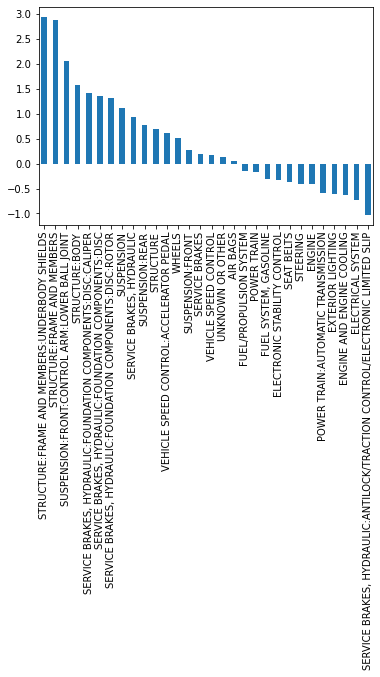

In [10]:
significant_values = get_significant_values(
    df['MODELTXT']=='TUNDRA',
    df['COMPDESC'], 
    30
)
significant_values.plot(kind='bar')

## Why are STRUCTURE: FRAME AND MEMBERS:UNDERBODY SHIELDS highly related to "Toyota Tundra"?
To answer that question, let us look closer at which fields are related to `STRUCTURE: FRAME AND MEMBERS:UNDERBODY SHIELDS`.



In [11]:
selected_complaints = ((df['MODELTXT'] == 'TUNDRA') & (df['COMPDESC'] == significant_values.index[0]))

### Treands related to Model Year and Mileage

The following code displays the relevancy of complaints for each model year from 2000 to 2020, and separately a bar graph of the relevancy to the car's mileage. By far, the most related model year is 2000. And in this case, the more mileage a car has the more related it is.

<AxesSubplot:>

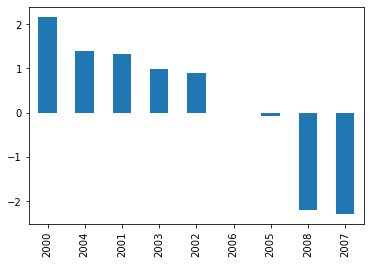

In [12]:
get_significant_values(selected_complaints, df['YEARTXT'], 30).plot(kind='bar')

<AxesSubplot:>

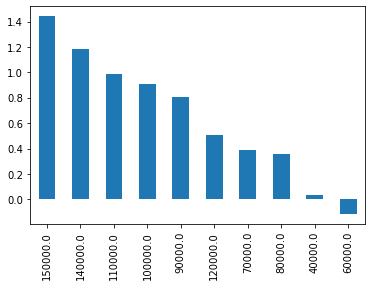

In [13]:
get_significant_values(selected_complaints, pd.to_numeric(df['MILES']).round(-4), 10).plot(kind='bar')

### View data in a heatmap
The code below displays a heat map of relevant data in the United States.
Many of the relevant complaints are related to the New England area.

In [14]:
!pip install folium

     |████████████████████████████████| 94 kB 2.0 MB/s eta 0:00:01


In [15]:
import folium

url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=get_significant_values(
        selected_complaints,
        df['STATE'],
        30
    ).rename_axis('State').reset_index(name='Relevancy'),
    columns=["State", "Relevancy"],
    key_on="feature.id",
    fill_color="YlGn",
    nan_fill_color="white",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Relevancy",
).add_to(m)

folium.LayerControl().add_to(m)

m